In [1]:
"""
Analysis pipeline on BERT models
"""

import numpy as np
import matplotlib.pyplot as plt

from transformers import AutoModel, AutoModelForCausalLM, AutoModelForMaskedLM, AutoModelForSeq2SeqLM
from transformers import BertModel, AlbertModel, DistilBertModel, RobertaModel, BartModel, OpenAIGPTModel, GPT2Model

/opt/homebrew/Caskroom/miniconda/base/envs/attention-geometry/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def decomposition_SN(A):
    
    S = np.linalg.norm(.5 * (A + A.T), 'fro') / np.linalg.norm(A, 'fro')
    N = np.linalg.norm(.5 * ((A - A.T)), 'fro') / np.linalg.norm(A, 'fro')

    return S, N

def decomposition_blocks(l,A):
    S = np.zeros(l)
    N = np.zeros(l)

    for i, layer in enumerate(range(l)):
        S[i], N[i] = decomposition_SN(A[layer])
    return  S, N

In [3]:
def get_matricesBERT(model):

    layers = len(model.encoder.layer)    
    M = []
    for l in range(layers):
        Wq = model.encoder.layer[l].attention.self.query.weight.detach().numpy()
        Wk = model.encoder.layer[l].attention.self.key.weight.detach().numpy()
        M.append(Wq@(Wk.T))        

    return M

def get_matricesALBERT(model):

    layers = len(model.encoder.albert_layer_groups)    
    M = []
    for l in range(layers):
        Wq = model.encoder.albert_layer_groups[l].albert_layers[0].attention.query.weight.detach().numpy()
        Wk = model.encoder.albert_layer_groups[l].albert_layers[0].attention.key.weight.detach().numpy()
        M.append(Wq@(Wk.T))        

    return M

def get_matricesDistillBERT(model):

    layers = len(model.transformer.layer)
    M = []
    for l in range(layers):
        Wq = model.transformer.layer[l].attention.q_lin.weight.detach().numpy()
        Wk = model.transformer.layer[l].attention.k_lin.weight.detach().numpy()
        M.append(Wq@(Wk.T))        

    return M

def get_matricesBART(model):

    layers = len(model.encoder.layers)  
    M = []
    for l in range(layers):
        Wq = model.encoder.layers[l].self_attn.q_proj.weight.detach().numpy()
        Wk = model.encoder.layers[l].self_attn.k_proj.weight.detach().numpy()
        M.append(Wq@(Wk.T))        

    return M

def get_matricesGPT(d,model):

    layers = len(model.h)  
    M = []
    for l in range(layers):
        Wq = model.h[l].attn.c_attn.weight[:,:d].detach().numpy()
        Wk = model.h[l].attn.c_attn.weight[:,d:2*d].detach().numpy()
        M.append(Wq@(Wk.T))        

    return M

def get_matricesDistillGPT(d,model):

    layers = len(model.transformer.h)  
    M = []
    for l in range(layers):
        Wq = model.transformer.h[l].attn.c_attn.weight[:,:d].detach().numpy()
        Wk = model.transformer.h[l].attn.c_attn.weight[:,d:2*d].detach().numpy()
        M.append(Wq@(Wk.T))        

    return M

def get_matricesDistillROBERTA(model):

    layers = len(model.roberta.encoder.layer)    
    M = []
    for l in range(layers):
        Wq = model.roberta.encoder.layer[l].attention.self.query.weight.detach().numpy()
        Wk = model.roberta.encoder.layer[l].attention.self.key.weight.detach().numpy()
        M.append(Wq@(Wk.T))        

    return M

def get_matricesT5(model):

    layers = len(model.encoder.block)
    M = []
    for l in range(layers):
        Wq = model.encoder.block[l].layer[0].SelfAttention.q.weight.detach().numpy()
        Wk = model.encoder.block[l].layer[0].SelfAttention.k.weight.detach().numpy()
        M.append(Wq@(Wk.T))        

    return M

def get_matricesOPT(model):

    layers = len(model.model.decoder.layers)
    M = []
    for l in range(layers):
        Wq = model.model.decoder.layers[l].self_attn.q_proj.weight.detach().numpy()
        Wk = model.model.decoder.layers[l].self_attn.k_proj.weight.detach().numpy()
        M.append(Wq@(Wk.T))        

    return M

def get_matricesGPTneo(model):

    layers = len(model.transformer.h)
    M = []
    for l in range(layers):
        Wq = model.transformer.h[l].attn.attention.q_proj.weight.detach().numpy()
        Wk = model.transformer.h[l].attn.attention.k_proj.weight.detach().numpy()
        M.append(Wq@(Wk.T))        

    return M

def get_matricesGPTneox(d,l,h,dh,model):
    
    S = np.zeros((l,h))
    N = np.zeros((l,h))

    for i in range(l):
        print(l)

        Wq = model.gpt_neox.layers[i].attention.query_key_value.weight[:d,:].detach().numpy()
        Wk = model.gpt_neox.layers[i].attention.query_key_value.weight[d:2*d,:].detach().numpy()
        M = Wq@(Wk.T)

        for j, head in enumerate(range(0,d,dh)):
            S[i,j], N[i,j] = decomposition_SN(M[head:head+dh,head:head+dh])    

    return S ,N

def get_matricesGPTj(model):

    layers = len(model.transformer.h)
    M = []
    for l in range(layers):
        Wq = model.transformer.h[l].attn.q_proj.weight.detach().numpy()
        Wk = model.transformer.h[l].attn.k_proj.weight.detach().numpy()
        M.append(Wq@(Wk.T))        

    return M

def decomposition_blocks(d,l,h,dh,A):
    
    S = np.zeros((l,h))
    N = np.zeros((l,h))

    for i, layer in enumerate(range(l)):
        for j, head in enumerate(range(0,d,dh)):
            S[i,j], N[i,j] = decomposition_SN(A[layer][head:head+dh,head:head+dh])
    return  S, N

In [ ]:
"""
- KEY (str): model name
- VALUES (list): [layers (int), embedding dim (int), heads (int), head dim (int), S scores, N scores]
"""
models = {}

In [4]:
""" 

BERT models 
 - MODEL: Bidirectional Encoder-only transformer
 - DATASETS: BookCorpus & English Wikipedia
 - OBJECTIVES: Masked Language Modeling (MLM), Next Sentence Prediction (NSP)

BERT base (l = 12, d = 768, h = 12 ; 110M parameters)

"""
l = 2

model = AutoModel.from_pretrained("google/bert_uncased_L-2_H-128_A-2")
M = get_matricesBERT(model)
SBert_tiny, NBert_tiny = decomposition_blocks(l,M)

l = 4
model = AutoModel.from_pretrained("google/bert_uncased_L-4_H-256_A-4")
M = get_matricesBERT(model)
SBert_mini, NBert_mini = decomposition_blocks(l,M)

l = 4
model = AutoModel.from_pretrained("google/bert_uncased_L-4_H-512_A-8")
M = get_matricesBERT(model)
SBert_small, NBert_small = decomposition_blocks(l,M)

l = 8
model = AutoModel.from_pretrained("google/bert_uncased_L-8_H-512_A-8")
M = get_matricesBERT(model)
SBert_medium, NBert_medium = decomposition_blocks(l,M)

l = 12
model = BertModel.from_pretrained("bert-base-uncased")
M = get_matricesBERT(model)
SBert_base, NBert_base = decomposition_blocks(l,M)

l = 24
model = BertModel.from_pretrained("bert-large-uncased")
M = get_matricesBERT(model)
SBert_large, NBert_large = decomposition_blocks(l,M)

l = 24
model = BertModel.from_pretrained("bert-large-uncased-whole-word-masking")
M = get_matricesBERT(model)
SBert_largeMasking, NBert_largeMasking = decomposition_blocks(l,M)

In [5]:
""" 
Generative Pre-trained Transformer (GPT)


Fine-tuning approach: introduce minimal, task-specific parameters, and is trained on downstream tasks by fine-tuning all pre-trained parameters
"""

'GPT 1'
l = 12
d = 768
model = OpenAIGPTModel.from_pretrained("openai-gpt")
M = get_matricesGPT(d,model)
SGPT, NGPT = decomposition_blocks(l,M)

'GPT2'
l = 12
d = 768
model = GPT2Model.from_pretrained('gpt2')
M = get_matricesGPT(d,model)
SGPT2, NGPT2 = decomposition_blocks(l,M)

'GPT2 medium'
l = 24
d = 1024
model = GPT2Model.from_pretrained('gpt2-medium')
M = get_matricesGPT(d,model)
SGPT2_medium, NGPT2_medium = decomposition_blocks(l,M)

'GPT2 large'
l = 36
model = GPT2Model.from_pretrained('gpt2-large')
M = get_matricesGPT(d,model)
SGPT2_large, NGPT2_large = decomposition_blocks(l,M)

'GPT2 xl'
l = 48
model = GPT2Model.from_pretrained('gpt2-xl')
M = get_matricesGPT(d,model)
SGPT2_xl, NGPT2_xl = decomposition_blocks(l,M)

In [6]:
""" 

ROBERTA models 
 - MODEL: 
 - DATASETS: BookCorpus & English Wikipedia
 - OBJECTIVES: Masked Language Modeling (MLM), Next Sentence Prediction (NSP)

BERT base (l = 12, d = 768, h = 12 ; 110M parameters)
"""

l = 12
model = RobertaModel.from_pretrained('roberta-base')
M = get_matricesBERT(model)
SROBERTA_base, NROBERTA_base = decomposition_blocks(l,M)

l = 24
model = RobertaModel.from_pretrained('roberta-large')
M = get_matricesBERT(model)
SROBERTA_large, NROBERTA_large = decomposition_blocks(l,M)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
""" 

ALBERT models 
 - MODEL: 
 - DATASETS: BookCorpus & English Wikipedia
 - OBJECTIVES: Masked Language Modeling (MLM), Next Sentence Prediction (NSP)

BERT base (l = 12, d = 768, h = 12 ; 110M parameters)
"""

'ALBERT base model (l = 12, d = 768, h = 12 ; tot num parameters 110M)'
l = 1
model = AlbertModel.from_pretrained("albert-base-v2")
M = get_matricesALBERT(model)
SALBERT_base, NALBERT_base = decomposition_blocks(l,M)

'ALBERT large model (l = 12, d = 768, h = 12 ; tot num parameters 110M)'
l = 1
model = AlbertModel.from_pretrained("albert-large-v2")
M = get_matricesALBERT(model)
SALBERT_large, NALBERT_large = decomposition_blocks(l,M)

'ALBERT xlarge model (l = 12, d = 768, h = 12 ; tot num parameters 110M)'
l = 1
model = AlbertModel.from_pretrained("albert-xlarge-v2")
M = get_matricesALBERT(model)
SALBERT_xlarge, NALBERT_xlarge = decomposition_blocks(l,M)

'ALBERT xxlarge model (l = 12, d = 768, h = 12 ; tot num parameters 110M)'
l = 1
model = AlbertModel.from_pretrained("albert-xxlarge-v2")
M = get_matricesALBERT(model)
SALBERT_xxlarge, NALBERT_xxlarge = decomposition_blocks(l,M)

In [8]:
""" 

DISTILL models 
 - MODEL: 
 - DATASETS: BookCorpus & English Wikipedia
 - OBJECTIVES: Masked Language Modeling (MLM), Next Sentence Prediction (NSP)

BERT base (l = 12, d = 768, h = 12 ; 110M parameters)
"""

'DistillBERT base model (l = 12, d = 768, h = 12 ; tot num parameters 110M)'
l = 6
model = DistilBertModel.from_pretrained("distilbert-base-uncased")
M = get_matricesDistillBERT(model)
SDistillBERT, NDistillBERT = decomposition_blocks(l,M)


'DistillGPT2 base model (l = 12, d = 768, h = 12 ; tot num parameters 110M)'
l = 6
d = 768
model = AutoModelForCausalLM.from_pretrained("distilbert/distilgpt2")
M = get_matricesDistillGPT(d,model)
SDistillGPT2, NDistillGPT2 = decomposition_blocks(l,M)


'DistillROBERTA base model (l = 12, d = 768, h = 12 ; tot num parameters 110M)'
l = 6
model = AutoModelForMaskedLM.from_pretrained("distilbert/distilroberta-base")
M = get_matricesDistillROBERTA(model)
SDistillROBERTA, NDistillROBERTA = decomposition_blocks(l,M)

Some weights of the model checkpoint at distilbert/distilroberta-base were not used when initializing RobertaForMaskedLM: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [9]:
""" 

T5 models 
 - MODEL: 
 - DATASETS: BookCorpus & English Wikipedia
 - OBJECTIVES: Masked Language Modeling (MLM), Next Sentence Prediction (NSP)

BERT base (l = 12, d = 768, h = 12 ; 110M parameters)
"""

'T5 small model (l = 12, d = 768, h = 12 ; tot num parameters 110M)'
l = 6
model = AutoModelForSeq2SeqLM.from_pretrained("google-t5/t5-small")
M = get_matricesT5(model)
ST5_small, NT5_small = decomposition_blocks(l,M)

'T5 base model (l = 12, d = 768, h = 12 ; tot num parameters 110M)'
l = 12
model = AutoModelForSeq2SeqLM.from_pretrained("google-t5/t5-base")
M = get_matricesT5(model)
ST5_base, NT5_base = decomposition_blocks(l,M)

'T5 large model (l = 12, d = 768, h = 12 ; tot num parameters 110M)'
l = 24
model = AutoModelForSeq2SeqLM.from_pretrained("google-t5/t5-large")
M = get_matricesT5(model)
ST5_large, NT5_large = decomposition_blocks(l,M)

'T5 3B model (l = 12, d = 768, h = 12 ; tot num parameters 110M)'
l = 24
model = AutoModelForSeq2SeqLM.from_pretrained("google-t5/t5-3B")
M = get_matricesT5(model)
ST5_3B, NT5_3B = decomposition_blocks(l,M)

(0.0, 1.0)

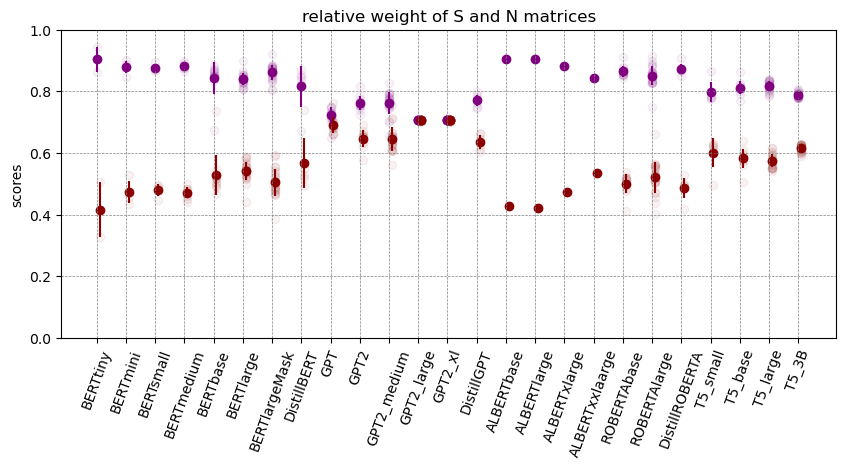

In [13]:
SList = [SBert_tiny, SBert_mini, SBert_small, SBert_medium, SBert_base, SBert_large, SBert_largeMasking, SDistillBERT, 
         SGPT, SGPT2, SGPT2_medium, SGPT2_large, SGPT2_xl, SDistillGPT2, 
         SALBERT_base, SALBERT_large, SALBERT_xlarge, SALBERT_xxlarge,
         SROBERTA_base, SROBERTA_large, SDistillROBERTA, 
         ST5_small, ST5_base, ST5_large, ST5_3B
         ]

NList = [NBert_tiny, NBert_mini, NBert_small, NBert_medium, NBert_base, NBert_large, NBert_largeMasking, NDistillBERT,
         NGPT, NGPT2, NGPT2_medium, NGPT2_large, NGPT2_xl, NDistillGPT2, 
         NALBERT_base, NALBERT_large, NALBERT_xlarge, NALBERT_xxlarge, 
         NROBERTA_base, NROBERTA_large, NDistillROBERTA,
         NT5_small, NT5_base, NT5_large, NT5_3B
         ]

names = ['BERTtiny', 'BERTmini', 'BERTsmall', 'BERTmedium',  'BERTbase', 'BERTlarge', 'BERTlargeMask', 'DistillBERT', 
         'GPT', 'GPT2', 'GPT2_medium', 'GPT2_large', 'GPT2_xl', 'DistillGPT', 
         'ALBERTbase', 'ALBERTlarge', 'ALBERTxlarge', 'ALBERTxxlaarge',
         'ROBERTAbase', 'ROBERTAlarge', 'DistillROBERTA',          
         'T5_small', 'T5_base', 'T5_large', 'T5_3B' 
         ]

plt.figure(figsize=(10,4))

for i, model in enumerate(SList):

    plt.scatter(i*np.ones(SList[i].size),SList[i].flatten(),color='purple',alpha=.05)
    plt.scatter(i,SList[i].flatten().mean(),color='purple')
    plt.errorbar(i,SList[i].flatten().mean(),
                SList[i].flatten().std(),
                color='purple')
    plt.scatter((i+.1)*np.ones(NList[i].size),NList[i].flatten(),color='darkred',alpha=.05)
    plt.scatter(i+.1,NList[i].flatten().mean(),color='darkred')
    plt.errorbar(i+.1,NList[i].flatten().mean(),
                NList[i].flatten().std(),
                color='darkred')
    
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
plt.title('relative weight of S and N matrices')
plt.ylabel('scores')
plt.xticks(np.arange(len(names)),names)
plt.xticks(rotation=70)
plt.ylim(0,1)